In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import json
import numpy as np
import pickle
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# please change the path variables so it suits your enviroment
base_dir = "/content/drive/MyDrive/Colab Notebooks/"
csv_path = os.path.join(base_dir, "train_dataset.csv")
glove_path = os.path.join(base_dir, "glove/glove.6B.50d.txt")
model_save_path = os.path.join(base_dir, "nn_classifier_new.keras")
tokenizer_save_path = os.path.join(base_dir, "tokenizer_new.pkl")
label_encoder_save_path = os.path.join(base_dir, "label_encoder_new.pkl")
metrics_save_path = os.path.join(base_dir, "training_metrics_new.csv")


df = pd.read_csv(csv_path)
all_contexts = df["context"].astype(str).tolist()
all_labels = df["original_label"].astype(str).tolist()

#Label encoding
label_encoder = LabelEncoder().fit(all_labels)
y_int = label_encoder.transform(all_labels)
y_cat = to_categorical(y_int)

# Save the label encoder
with open(label_encoder_save_path, "wb") as f:
    pickle.dump(label_encoder, f)

# Tokenization
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_contexts)
vocab_size = len(tokenizer.word_index) + 1

# Save tokenizer
with open(tokenizer_save_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(all_contexts)
padded_sequences = pad_sequences(sequences, maxlen=20, padding="post")


X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    y_cat,
    test_size=0.2,
    stratify=y_int,
    random_state=5544
)

# Build embedding matrix
embedding_matrix = np.zeros((vocab_size, 50), dtype="float32")
with open(glove_path, encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        idx = tokenizer.word_index.get(word)
        if idx:
            embedding_matrix[idx] = vector

# Define model
input_layer = Input(shape=(20,))
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=50,
    weights=[embedding_matrix],
    trainable=False
)(input_layer)
x = Flatten()(embedding_layer)
x = Dense(32, activation="relu")(x)
output_layer = Dense(len(label_encoder.classes_), activation="softmax")(x)

model = Model(input_layer, output_layer)
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

#Training loop with metric tracking
EPOCHS = 20
history_df = pd.DataFrame(columns=[
    "Epoch", "Training Loss", "Validation Loss", "Accuracy", "Precision", "Recall", "F1", "Weighted F1"
])

for epoch in range(EPOCHS):
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=1,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )

    train_loss = history.history["loss"][0]
    val_loss = history.history["val_loss"][0]

    y_pred = model.predict(X_test, verbose=0)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    acc = np.mean(y_pred_labels == y_true_labels)
    precision = precision_score(y_true_labels, y_pred_labels, average="weighted")
    recall = recall_score(y_true_labels, y_pred_labels, average="weighted")
    f1_weighted = f1_score(y_true_labels, y_pred_labels, average="weighted")
    f1_macro = f1_score(y_true_labels, y_pred_labels, average="macro")

    history_df.loc[epoch] = [
        epoch + 1,
        train_loss,
        val_loss,
        acc,
        precision,
        recall,
        f1_macro,
        f1_weighted
    ]


print(history_df)
history_df.to_csv(metrics_save_path, index=False)

# Evaluate model and save them
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_acc:.3f}")
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4045 - loss: 1.5176 - val_accuracy: 0.5243 - val_loss: 1.2727
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5973 - loss: 1.1208 - val_accuracy: 0.5855 - val_loss: 1.1432
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6831 - loss: 0.9174 - val_accuracy: 0.6111 - val_loss: 1.1189
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7255 - loss: 0.7904 - val_accuracy: 0.6292 - val_loss: 1.0903
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7689 - loss: 0.6913 - val_accuracy: 0.6467 - val_loss: 1.0911
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8005 - loss: 0.6055 - val_accuracy: 0.6648 - val_loss: 1.0850
451/451 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8268 - loss: 0.5354 - val_accuracy: 0.6723 - val_loss: 1.0821
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8448 - loss: 0.4831 - val_accuracy: 0.6735 - val_loss: 1.1050
451/451 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8609 - l

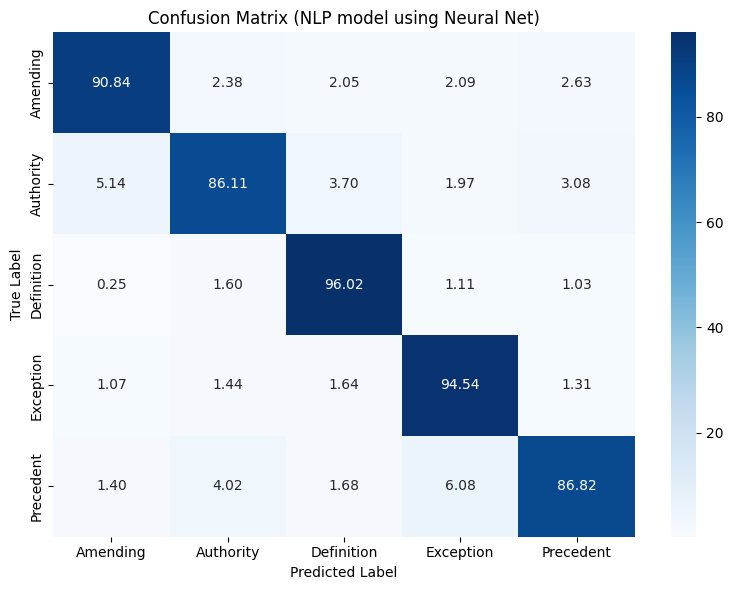

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Predict on test set
y_test_pred = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_test_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Compute raw confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Normalize: divide each row by row sum (convert to %)
cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

# Round for cleaner display
cm_rounded = np.round(cm_percent, 2)

# Get label names
labels = label_encoder.classes_

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_rounded,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels
)
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.title("Confusion Matrix (NLP model using Neural Net)")
plt.tight_layout()
plt.show()
